In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import sys

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans


# Dataset Understanding

## a. Import and Read Data

In [4]:
df = pd.read_csv ('/content/drive/MyDrive/Analysis/Mall Customer Segmentation/Data/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## b. Check Data Type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


## c. Check Missing Value

In [6]:
data_null = df.isnull().sum().reset_index()
data_null.columns = ['feature','missing_value']
data_null['percentage'] = round((data_null['missing_value']/len(df))*100,2)
data_null = data_null.sort_values('percentage', ascending=False).reset_index(drop=True)
data_null = data_null[data_null['percentage']>0]
data_null

,feature,missing_value,percentage


## d. Check Duplicated Value

In [7]:
print('Total of data duplicated :', df.duplicated().sum(), '\n')

Total of data duplicated : 0 



**Observation:**

1. The data type already matches the column.
2. No missing value.
3. No duplicate data.

# Exploratory Data Analysis

## a. Numeric Variables Distribution

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


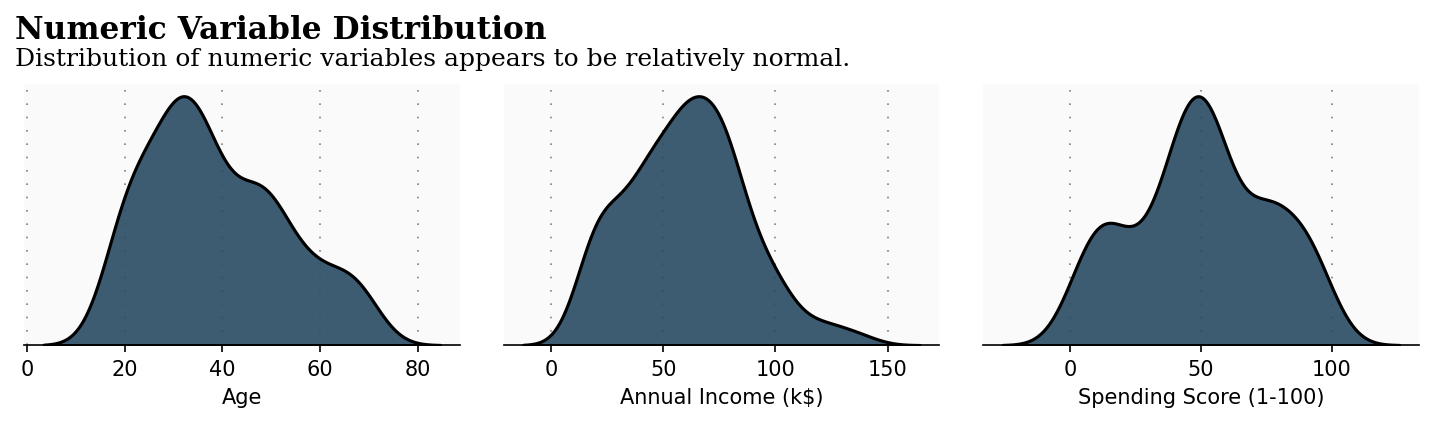

In [8]:
variables = [variable for variable in df.columns if variable not in ['CustomerID']]
nums = ['Age','Annual Income (k$)','Spending Score (1-100)']

fig = plt.figure(figsize=(12, 12), dpi=150)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()['ax'+str(plot)] = fig.add_subplot(gs[row, col])
        locals()['ax'+str(plot)].set_facecolor('#fafafa')
        locals()['ax'+str(plot)].tick_params(axis='y', left=False)
        locals()['ax'+str(plot)].get_yaxis().set_visible(False)
        for s in ['top','right','left']:
            locals()['ax'+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0
for variable in nums:
        sns.kdeplot(df[variable], ax=locals()['ax'+str(plot)], color='#284B63', shade=True, linewidth=1.5, ec='black', alpha=0.9, zorder=3, legend=False)
        locals()['ax'+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,7))
        plot += 1

fig.text(.12, .905, 'Numeric Variable Distribution', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(.12, .89, 'Distribution of numeric variables appears to be relatively normal.', fontsize=12, fontweight='light', fontfamily='serif')

plt.tight_layout()
plt.show()

**Obersevation:**

It can be seen that the distribution of Age, Annual Income, and Spending Score has a fairly normal distribution. Can use the mean value to find out the average value of each distribution.

## b. Age Distribution

In [9]:
age = df.copy()

def age_range(x):
    for i in range(1, 100):
        if x < 10*i :  return f'{(i-1) * 10} ~ {i*10 - 1}'

age['Age Range'] = age['Age'].apply(age_range)

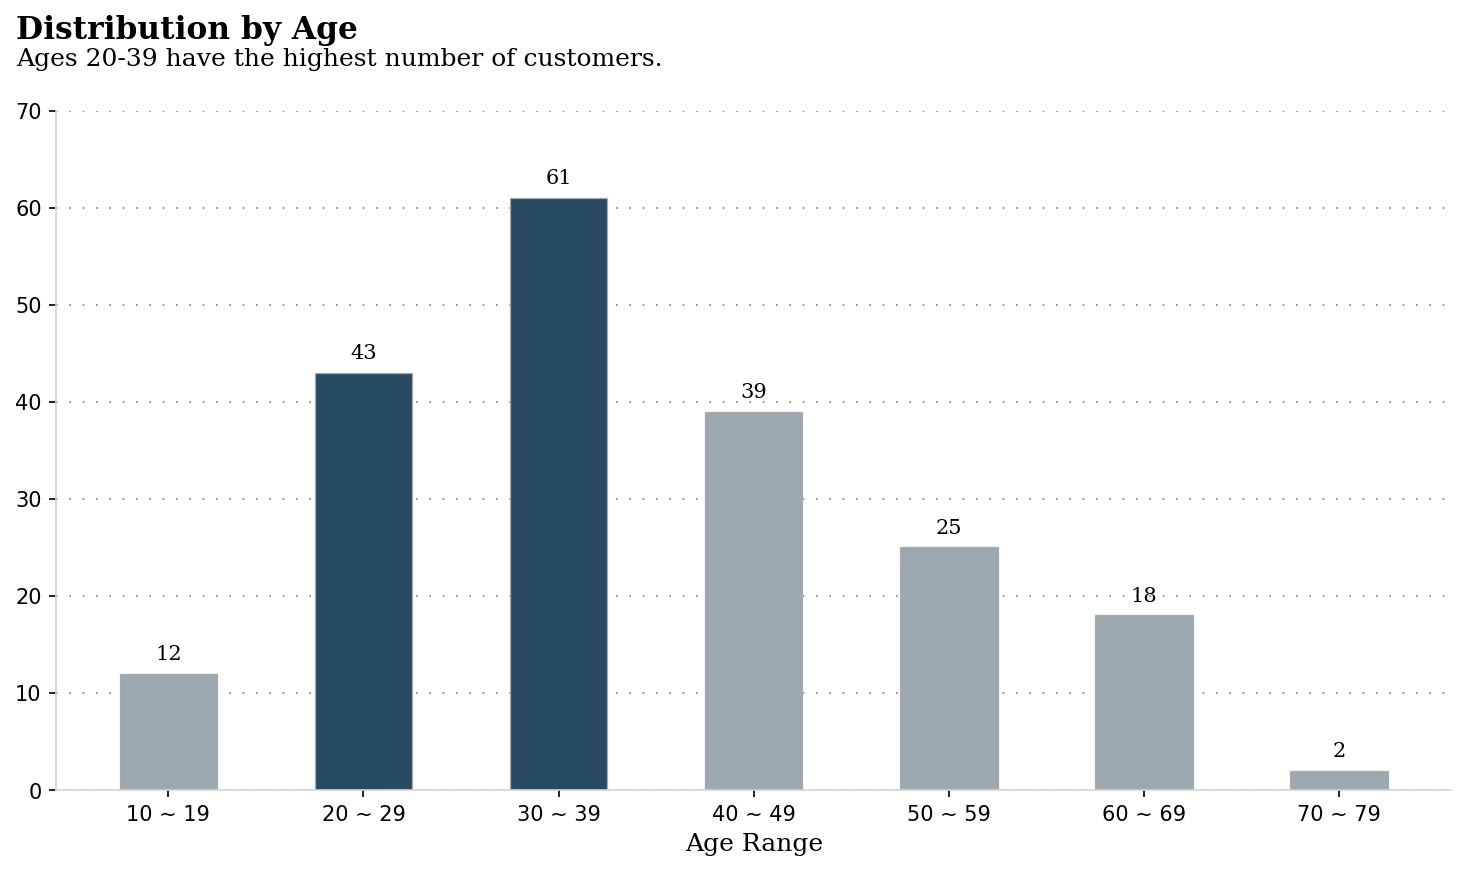

In [10]:
data_age = age['Age Range'].value_counts().sort_index()

color_map = ['#9DA9B1' for _ in range(7)]
color_map[2] = color_map[1] = '#284B63' 

fig, ax = plt.subplots(1,1, figsize=(12, 6), dpi=150)

ax.bar(data_age.index, data_age, width=0.5, ec='darkgray', linewidth=0.6, color=color_map)

for i in data_age.index:
    ax.annotate(f'{data_age[i]}', 
                   xy=(i, data_age[i] + 2),
                   va='center', ha='center', fontweight='light', fontfamily='serif')
    
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

grid_y_ticks = np.arange(0, 75, 10)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

ax.grid(which='major', axis='y', color='gray', linestyle=':', dashes=(1,7))

plt.xlabel('Age Range', fontsize=12, fontweight='light', fontfamily='serif',y=-1.5)

fig.text(0.1025, .96, 'Distribution by Age', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.1025, .93, 'Ages 20-39 have the highest number of customers.', fontsize=12, fontweight='light', fontfamily='serif')

plt.show()

## b. Distribution Age by Gender

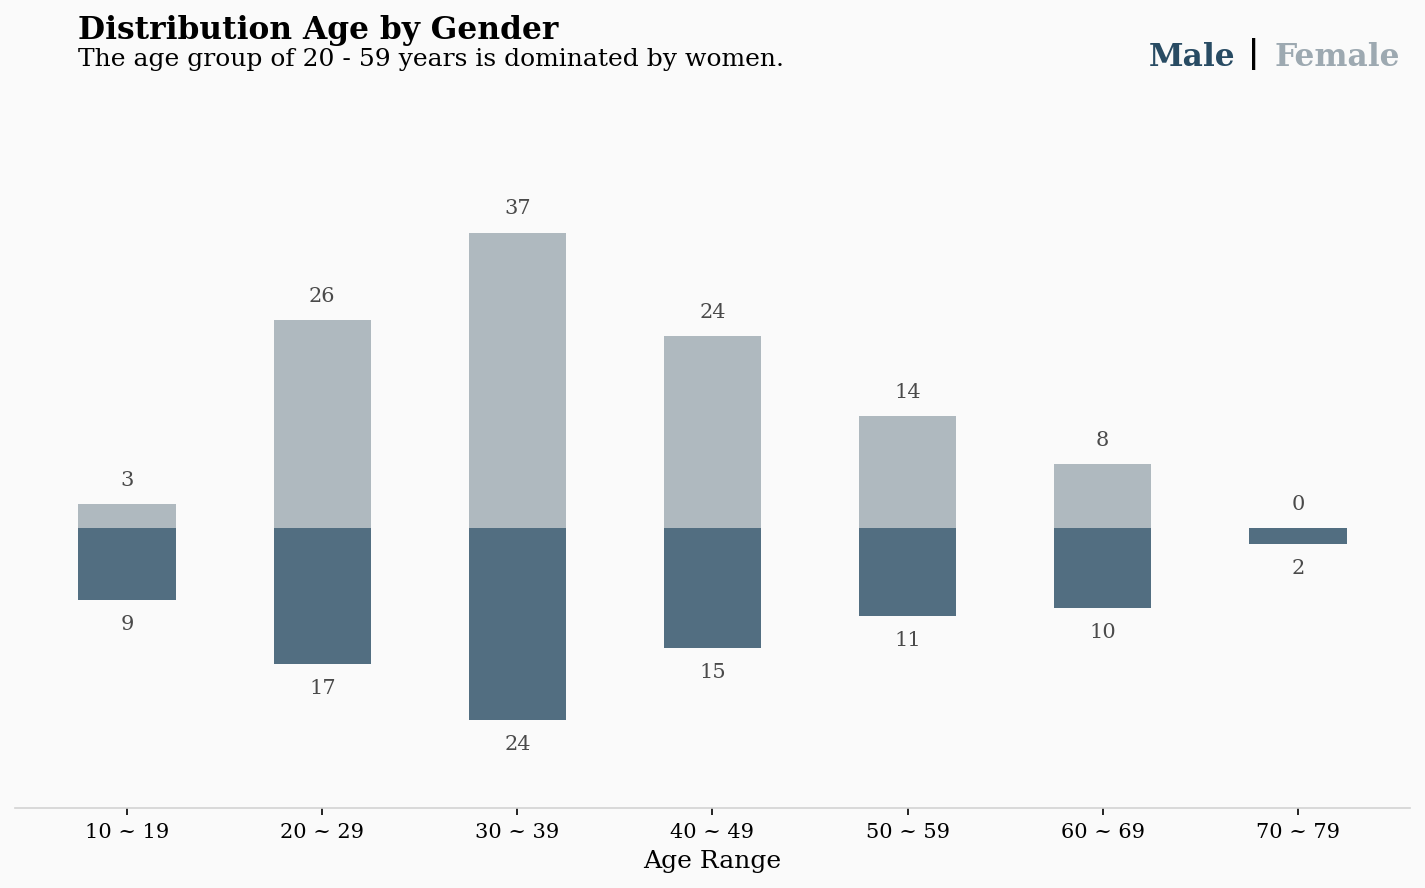

In [11]:
age_by_gender = age.groupby('Gender')['Age Range'].value_counts().unstack().sort_index().fillna(0).astype(int)

female = age_by_gender.loc['Female']
male = -age_by_gender.loc['Male']

fig, ax = plt.subplots(1,1, figsize=(12, 6), dpi=150)
ax.bar(male.index, male, width=0.5, color='#284B63', alpha=0.8, label='Male')
ax.bar(female.index, female, width=0.5, color='#9DA9B1', alpha=0.8, label='Female')
ax.set_ylim(-35, 50)

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

for i in female.index:
    ax.annotate(f"{female[i]}", 
                   xy=(i, female[i] + 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')   

for i in male.index:
    ax.annotate(f"{-male[i]}", 
                   xy=(i, male[i] - 3),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')
    
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.spines['bottom'].set_color('lightgray')

ax.set_xticklabels(age_by_gender.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, .98, 'Distribution Age by Gender', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.95, 'The age group of 20 - 59 years is dominated by women.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.755,0.95,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='#284B63')
fig.text(0.810,0.955,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.95,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='#9DA9B1')
plt.xlabel('Age Range', fontsize=12, fontweight='light', fontfamily='serif',y=-1.5)

plt.show()

## c. Annual income by Age

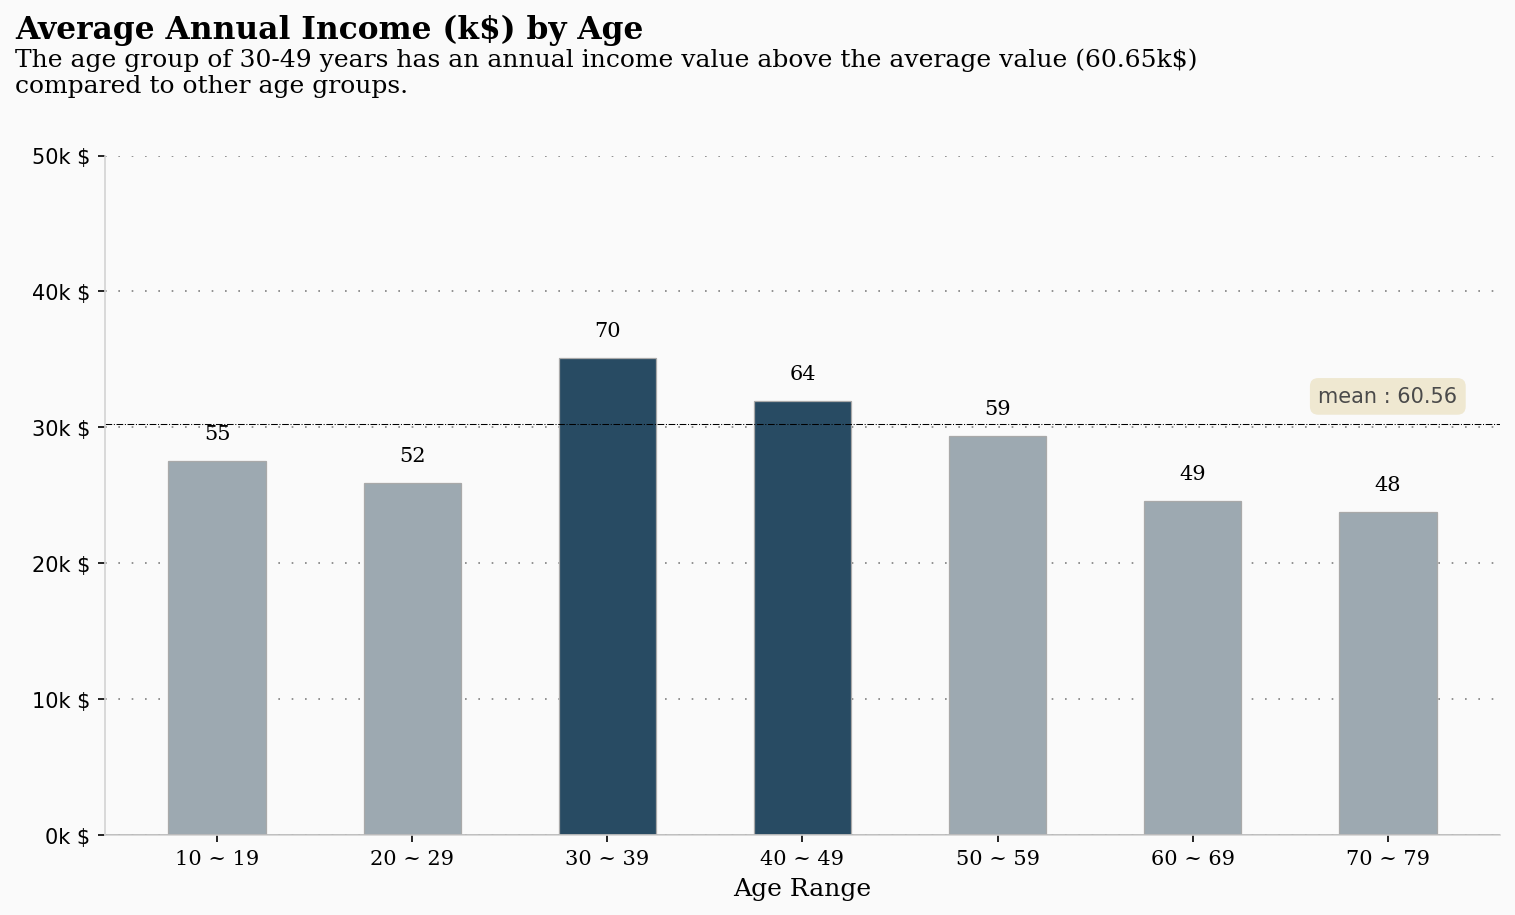

In [52]:
income_by_age = age.groupby('Age Range')['Annual Income (k$)'].mean().sort_index()

color_map = ['#9DA9B1' for _ in range(7)]
color_map[3] = color_map[2] = '#284B63' 

fig, ax = plt.subplots(1,1, figsize=(12, 6), dpi=150)
ax.bar(income_by_age.index, income_by_age, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

for i in income_by_age.index:
    ax.annotate(f"{round(income_by_age[i])}", 
                   xy=(i, income_by_age[i] + 4),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')
    
ax.set_xticklabels(income_by_age.index, fontfamily='serif', rotation=0)

ax.grid(axis='y', linestyle='-', alpha=1) 

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

mean = age['Annual Income (k$)'].mean()
ax.axhline(mean ,color='black', linewidth=.5, linestyle='dashdot')
ax.annotate(f"mean : {mean}", 
            xy=(6, mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

fig.text(0.075, 1.01, 'Average Annual Income (k$) by Age', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.075, 0.95, 'The age group of 30-49 years has an annual income value above the average value (60.65k$)\ncompared to other age groups.', fontsize=12, fontweight='light', fontfamily='serif')

grid_y_ticks = np.arange(0, 105, 20)
ax.set_yticks(grid_y_ticks)
ax.set_yticklabels(labels=['0k $','10k $','20k $','30k $','40k $','50k $','60k $','70k $','80k $','90k $','100k $'])
ax.set_axisbelow(True)

ax.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,7))

plt.xlabel('Age Range', fontsize=12, fontweight='light', fontfamily='serif',y=-1.5)

plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

plt.show()

## d. Spending Score by Age

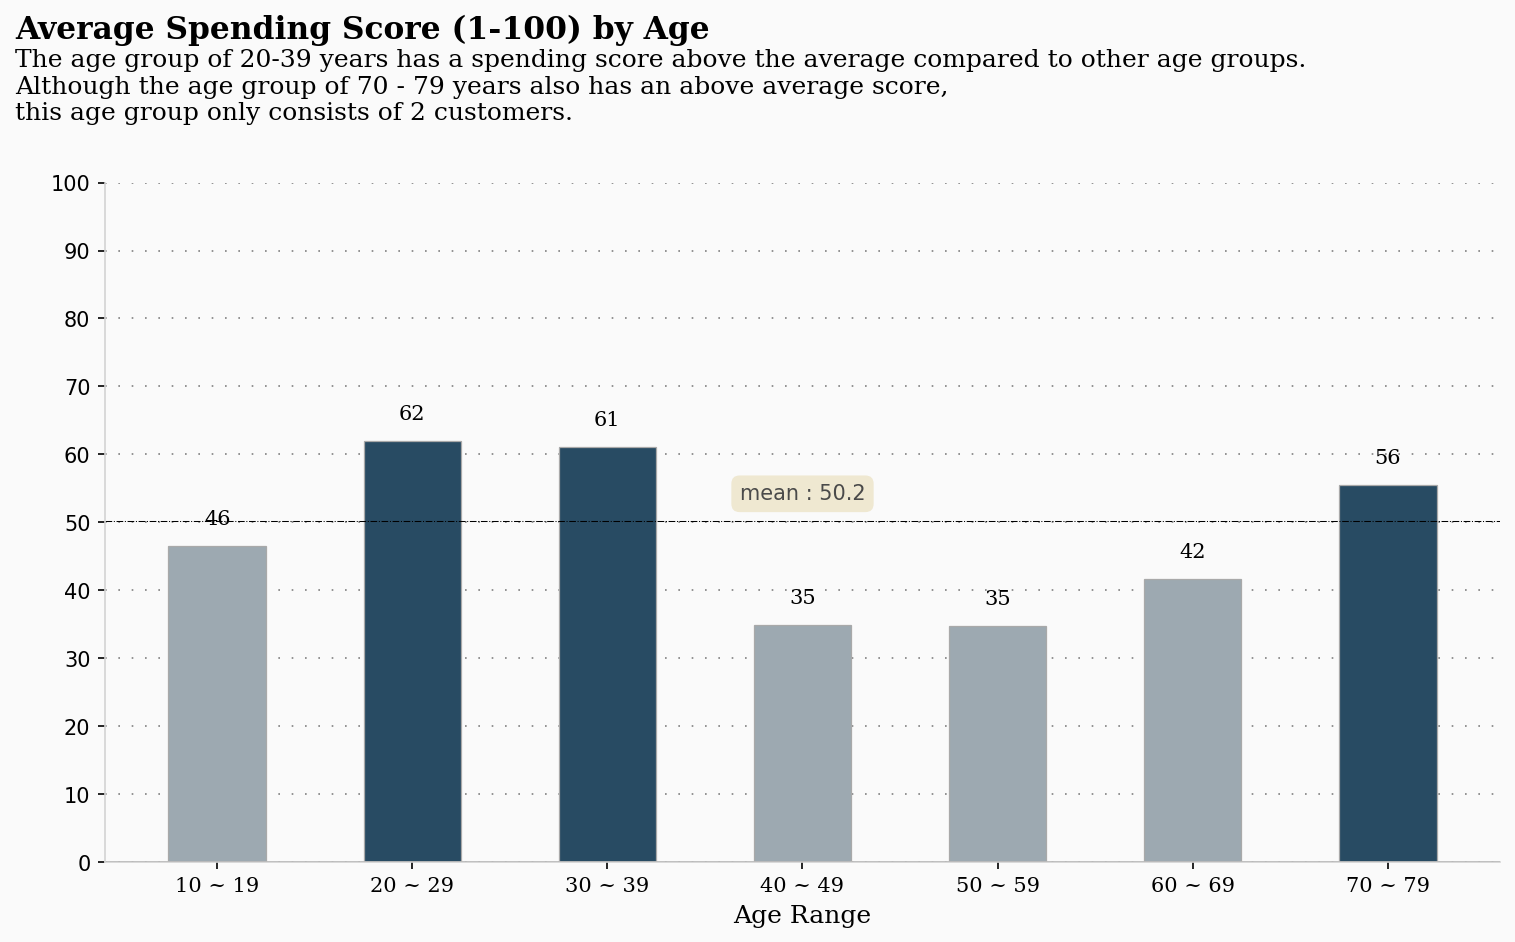

In [13]:
score_by_age = age.groupby('Age Range')['Spending Score (1-100)'].mean().sort_index()

color_map = ['#9DA9B1' for _ in range(7)]
color_map[6] = color_map[2] = color_map[1] = '#284B63' 

fig, ax = plt.subplots(1,1, figsize=(12, 6), dpi=150)
ax.bar(score_by_age.index, score_by_age, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

for i in score_by_age.index:
    ax.annotate(f"{round(score_by_age[i])}", 
                   xy=(i, score_by_age[i] + 4),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
    
ax.set_xticklabels(score_by_age.index, fontfamily='serif', rotation=0)

ax.grid(axis='y', linestyle='-', alpha=1) 

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax.set_facecolor(background_color)

# mean line + annotation
mean = age['Spending Score (1-100)'].mean()
ax.axhline(mean ,color='black', linewidth=.5, linestyle='dashdot')
ax.annotate(f"mean : {mean}", 
            xy=(3, mean + 4),
            va = 'center', ha='center',
            color='#4a4a4a',
            bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0))

fig.text(0.075, 1.04, 'Average Spending Score (1-100) by Age', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.075, 0.95, 'The age group of 20-39 years has a spending score above the average compared to other age groups.\nAlthough the age group of 70 - 79 years also has an above average score,\nthis age group only consists of 2 customers.', fontsize=12, fontweight='light', fontfamily='serif')

grid_y_ticks = np.arange(0, 105, 10)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

ax.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,7))

plt.xlabel('Age Range', fontsize=12, fontweight='light', fontfamily='serif',y=-1.5)

plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

plt.show()

## e. Correlation Between Numeric Variable

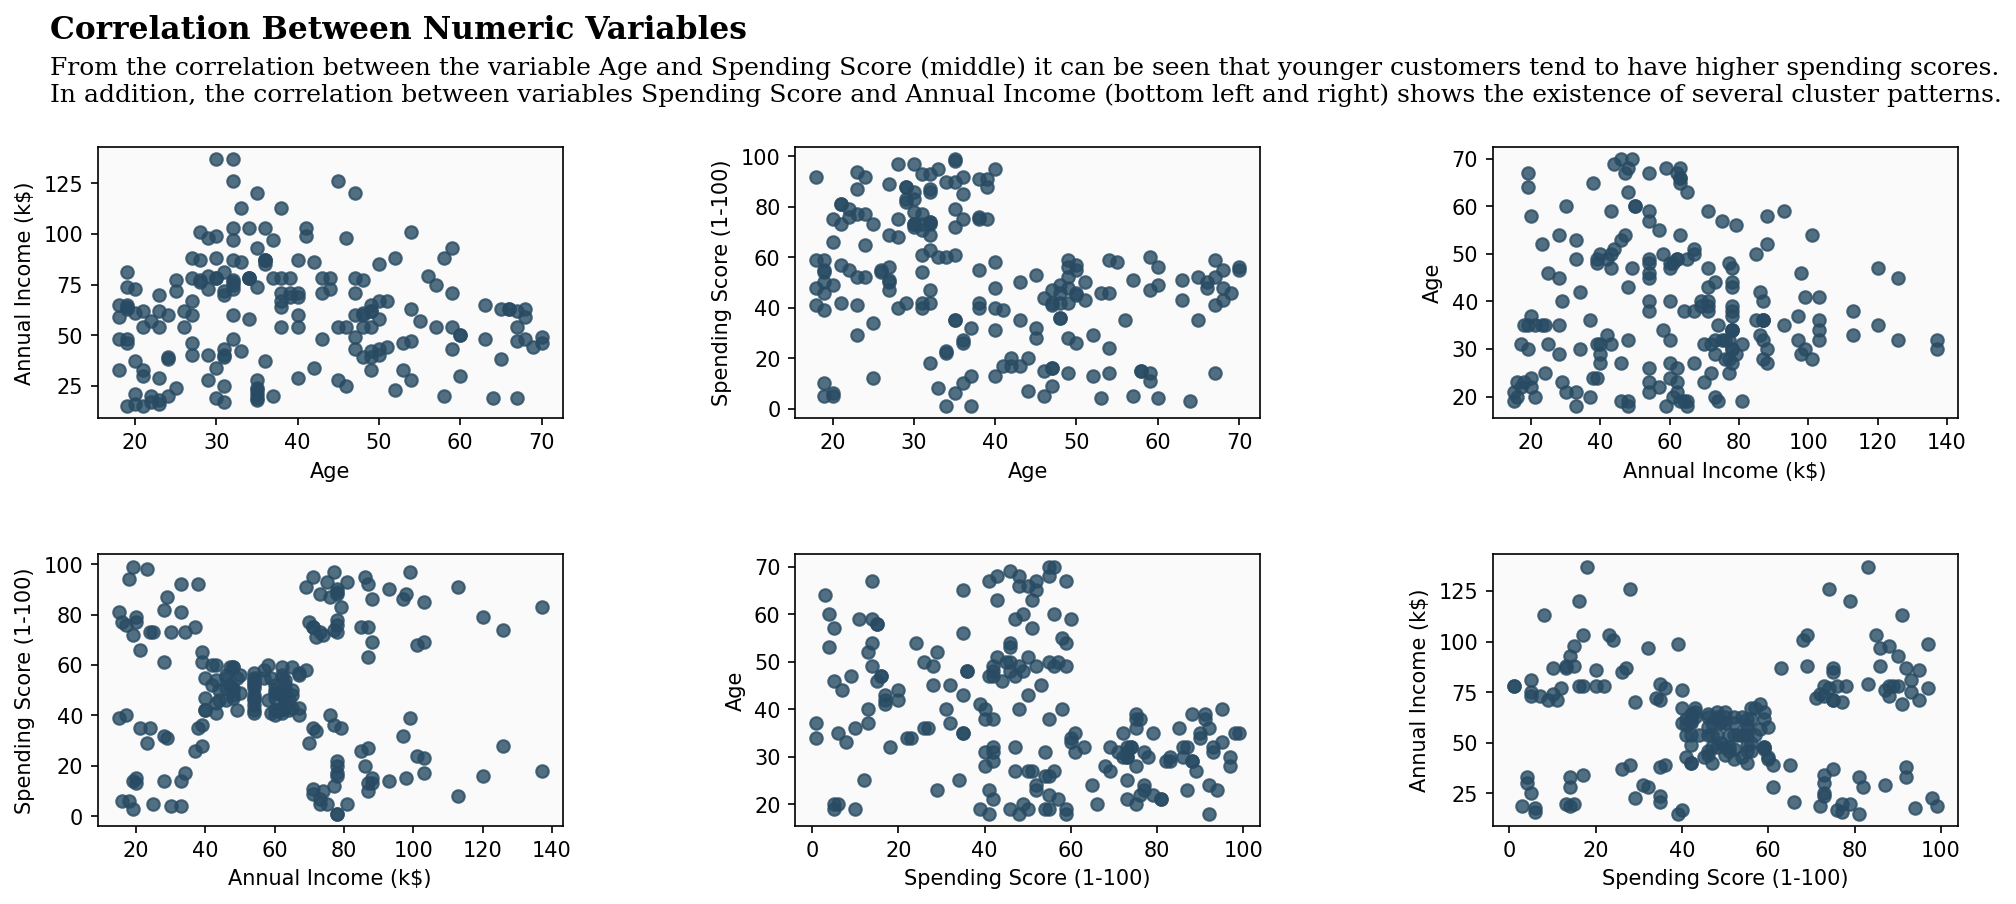

In [14]:
fig = plt.figure(figsize=(16, 6), dpi=150)

fig.text(0.105, 1, 'Correlation Between Numeric Variables', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.105, .93, 'From the correlation between the variable Age and Spending Score (middle) it can be seen that younger customers tend to have higher spending scores.\nIn addition, the correlation between variables Spending Score and Annual Income (bottom left and right) shows the existence of several cluster patterns.', fontsize=12, fontweight='light', fontfamily='serif')

n = 0 
for x in nums:
    for y in nums:
        if x==y:
          continue
        n += 1
        plt.subplot(2 , 3 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        sns.regplot(x = x , y = y , data = age,color='#284B63', fit_reg=False).set_facecolor("#fafafa")

plt.show()

## f. Correlation between variables Age & Spending Score

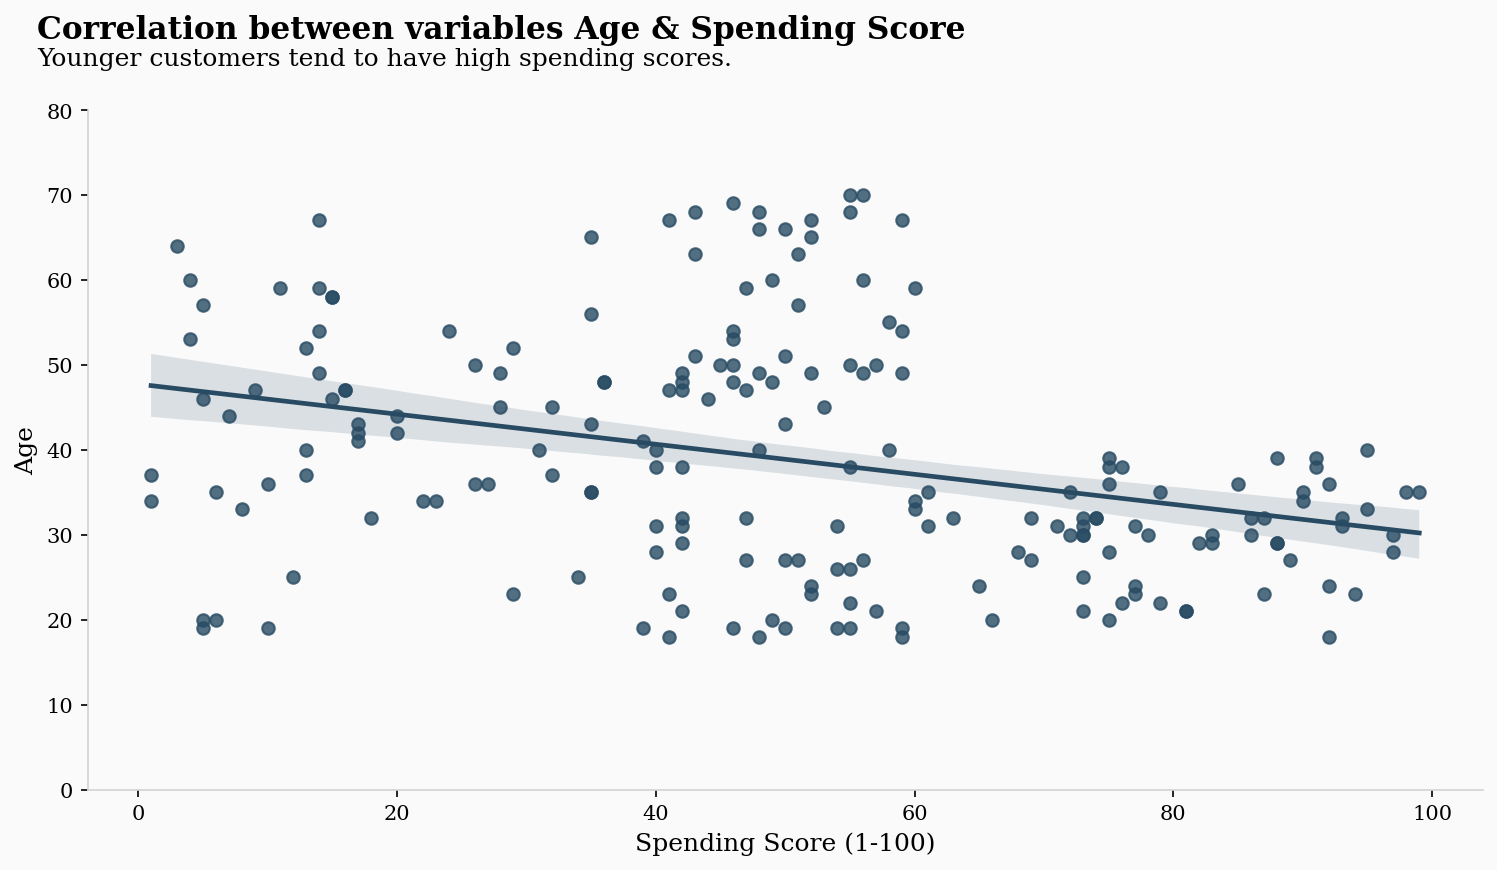

In [15]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

fig.text(.097, .96,'Correlation between variables Age & Spending Score', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(.097, .93,'Younger customers tend to have high spending scores.',fontfamily='serif',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)


ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

sns.regplot(x = 'Spending Score (1-100)' , y = 'Age' , data = df ,color='#284B63')

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_ylabel('Age',fontfamily='serif',fontsize=12)
ax.set_xlabel('Spending Score (1-100)',fontfamily='serif',fontsize=12)

ax.set_ylim(0, 80)

plt.show()

## g. Correlation between Annual Income & Spending Score

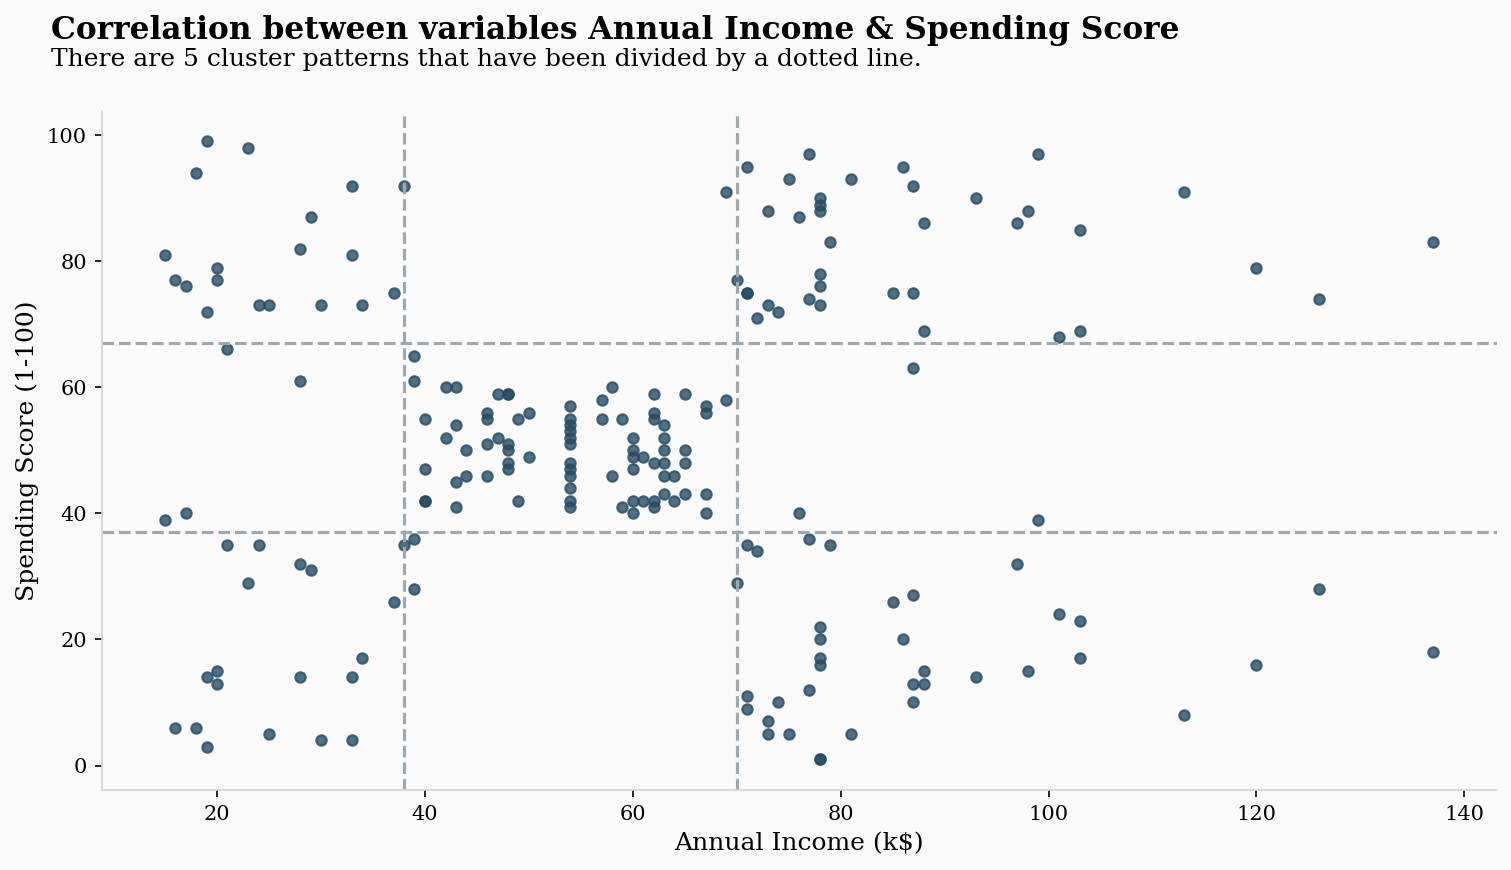

In [16]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

fig.text(.097, .96,'Correlation between variables Annual Income & Spending Score', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(.097, .93,'There are 5 cluster patterns that have been divided by a dotted line.',fontfamily='serif',fontsize=12)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)


ax.spines['bottom'].set_color('lightgray')
ax.spines['left'].set_color('lightgray')

ax.set_axisbelow(True)

plt.scatter(y = 'Spending Score (1-100)' , x = 'Annual Income (k$)' , data = df ,color='#284B63',s = 25 , alpha = 0.8 )

background_color = "#fafafa"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

plt.yticks(fontfamily='serif',fontweight='light')
plt.xticks(fontfamily='serif',fontweight='light')

ax.set_ylabel('Spending Score (1-100)',fontfamily='serif',fontsize=12)
ax.set_xlabel('Annual Income (k$)',fontfamily='serif',fontsize=12)

plt.axvline(38, color='#9DA9B1', linestyle='--')
plt.axvline(70, color='#9DA9B1', linestyle='--')
plt.axhline(37, color='#9DA9B1', linestyle='--')
plt.axhline(67, color='#9DA9B1', linestyle='--')

plt.show()

# Clustering

In [17]:
clustering = df.copy()

## a. Feature Annual Income & Spending Score

In [18]:
clustering_1 = clustering.drop(columns=['Gender','Age','CustomerID'], axis=1)
clustering_1.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [19]:
clustering_1_std = StandardScaler().fit_transform(clustering_1.astype(float))
clustering_1_std = pd.DataFrame(data = clustering_1_std, columns = ['Annual Income (k$)', 'Spending Score (1-100)'])
clustering_1_std.head()

,Annual Income (k$),Spending Score (1-100)
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


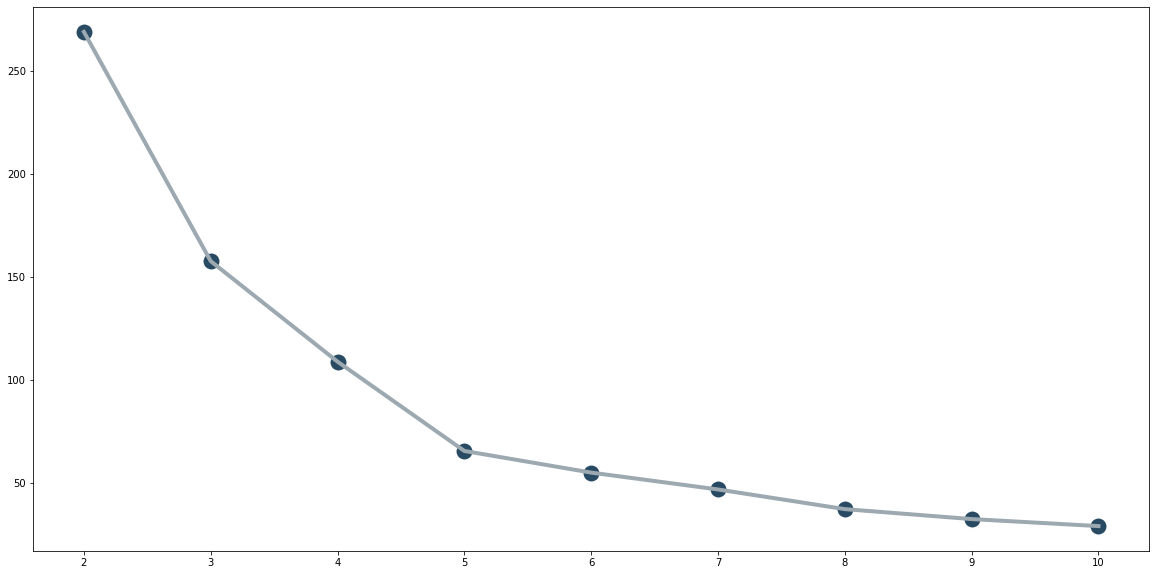

In [20]:
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(clustering_1_std.values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(20, 10))

sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#284B63',  linestyle='-')
sns.lineplot(x=range(2, 11), y=inertia, color='#9DA9B1', linewidth = 4)

In [21]:
kmeans = KMeans(n_clusters=5).fit(clustering_1_std)

clusters = kmeans.labels_

clustering_1['clusters'] = clusters

clustering_1_std['clusters'] = clusters

,clusters,Annual Income (k$),Spending Score (1-100)
0,0,25.727273,79.363636
1,1,86.538462,82.128205
2,2,55.296296,49.518519
3,3,88.200000,17.114286
4,4,26.304348,20.913043


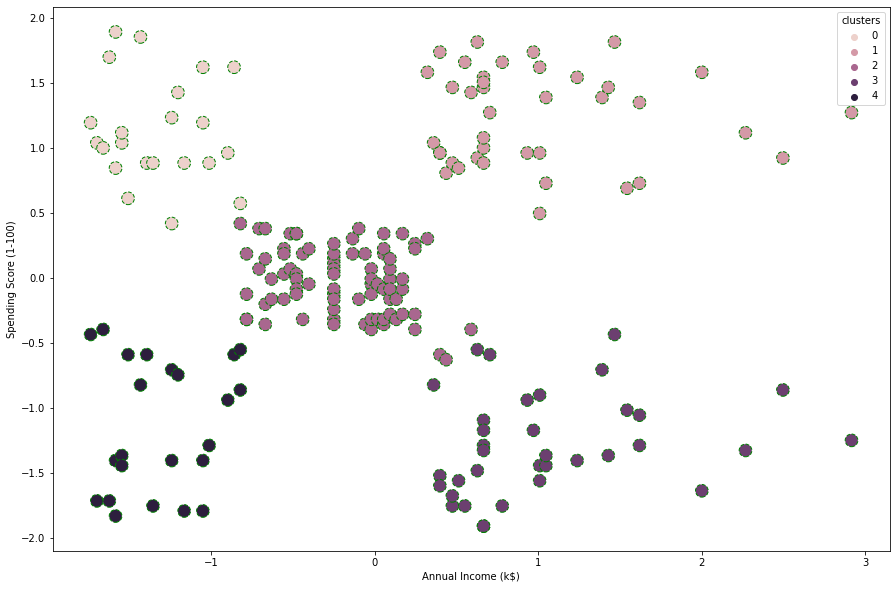

In [22]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=clustering_1_std,
    s=160,
    ax=ax
)

display(clustering_1.groupby('clusters').mean().reset_index())

In [23]:
clustering_1.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0
clusters,200.0,1.99,1.129726,0.0,1.00,2.0,3.0,4.0


**Interpretation:**

Customer segmentation based on features Total Annual Revenue and Expenditure Score is 5. A category will be created from each feature, if the average value is high and vice versa.

1. Cluster 0: Low Annual Income and High Spending Score.
2. Cluster 1: High Annual Income and High Spending Score.
3. Cluster 2: Low Annual Income and Low Spending Score.
4. Cluster 3: High Annual Income and Low Spending Score.
5. Cluster 4: Low Annual Income and Low Spending Score.

Clusters 2 and 4 have the same category, namely low Annual Income and low Spending Score. If we look in more detail, cluster 2 has each value closer to its mean value or it can be said that it is not too far from the mean value. Therefore, Cluster 2 will be included in the additional category, namely moderate. If you look at the plot, cluster 2 has a middle position. So, the clusters will be:

1. Cluster 0: Low Annual Income and High Spending Score.
2. Cluster 1: High Annual Income and High Spending Score.
3. Cluster 2: Moderate Annual Income and Moderate Spending Score.
4. Cluster 3: High Annual Income and Low Spending Score.
5. Cluster 4: Low Annual Income and Low Spending Score.


## b. Feature Age, Annual Income, & Spending Score

In [24]:
clustering_2 = clustering.copy()
clustering_2.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [25]:
from sklearn.preprocessing import StandardScaler

clustering_2_std = StandardScaler().fit_transform(clustering_2[nums].astype(float))

In [26]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)

pca.fit(clustering_2_std)
pcs = pca.transform(clustering_2_std)

clustering_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
clustering_pca.head()

,PC 1,PC 2
0,-0.615720,-1.763481
1,-1.665793,-1.820747
2,0.337862,-1.674799
3,-1.456573,-1.772430
4,-0.038465,-1.662740


[254.84344469415774, 177.23033142025503, 122.90870365241915, 98.95010475050222, 80.89118899063075, 70.32369808218458, 60.7437789113117, 50.22260696607924, 43.64772683806849]


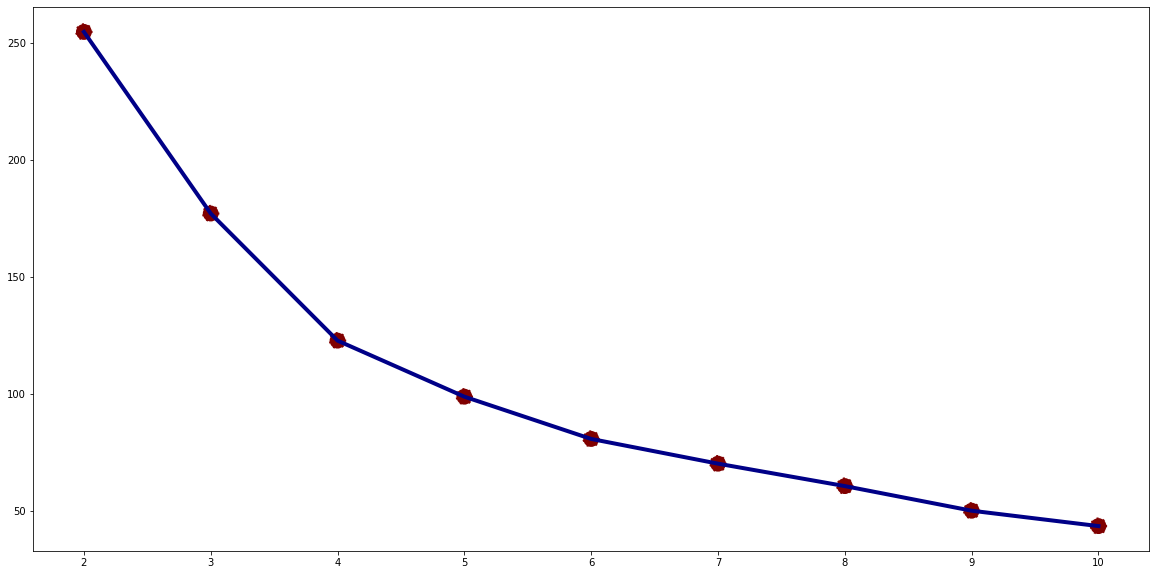

In [27]:
from sklearn.cluster import KMeans
inertia = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, algorithm='elkan')
    kmeans.fit(clustering_pca.values)
    inertia.append(kmeans.inertia_)


print(inertia)

plt.figure(figsize=(20, 10))

sns.lineplot(x=range(2, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(2, 11), y=inertia, s=300, color='#800000',  linestyle='--')

In [28]:
kmeans = KMeans(n_clusters=6).fit(clustering_pca)

In [29]:
clusters = kmeans.labels_

In [30]:
clustering_2['clusters'] = clusters

In [31]:
clustering_pca['clusters'] = clusters
clustering_pca.head()

,PC 1,PC 2,clusters
0,-0.615720,-1.763481,4
1,-1.665793,-1.820747,4
2,0.337862,-1.674799,1
3,-1.456573,-1.772430,4
4,-0.038465,-1.662740,4


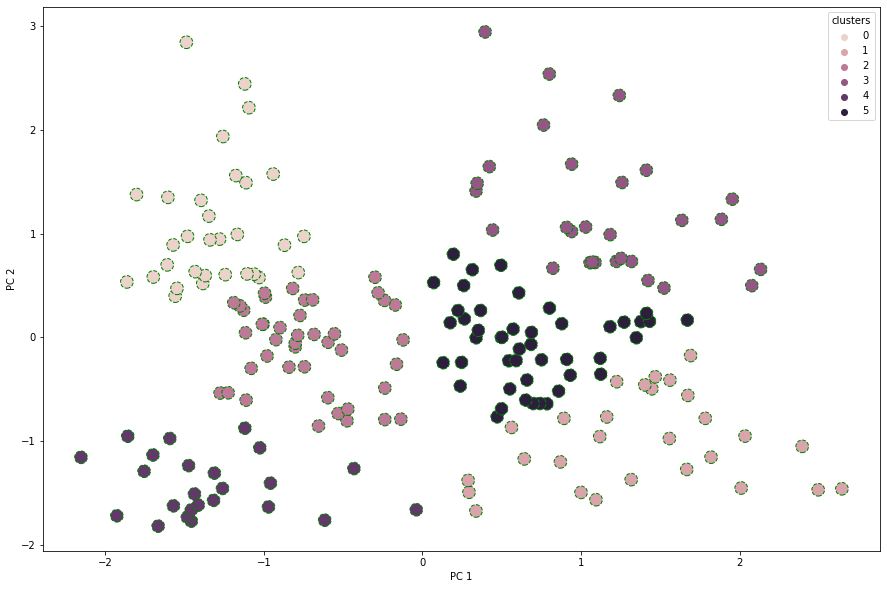

In [32]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=clustering_pca,
    s=160,
    ax=ax
)


In [33]:
display(clustering_2.groupby('clusters')[nums].mean().reset_index())

,clusters,Age,Annual Income (k$),Spending Score (1-100)
0,0,31.935484,90.451613,83.032258
1,1,52.285714,32.464286,26.821429
2,2,27.500000,59.023810,55.380952
3,3,44.793103,90.827586,17.793103
4,4,25.250000,24.916667,76.041667
5,5,49.043478,58.434783,44.521739


In [34]:
clustering_2[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


**Interpretation:**

Customer segmentation based on Age, Annual Income, and Spending Score features totaling 6. A category will be created for each feature if the value is higher than the mean and vice versa.

1. CLuster 0: Young Age, High Income, High Spending.
2. Cluster 1: Older Age, Low Income, Low Spending.
3. Cluster 2: Young Age, Low Income, High Spending.
4. Cluster 3: Older Age, High Income, Low Spending.
5. Cluster 4: Young Age, Low Income, High Spending.
6. Cluster 5: Older Age, High Income, Low Spending.

Clusters 2 and 4 have the same categories, namely Young Age, Low Income, High Spending. If we look in more detail, cluster 2 has each Annual Income and Spending Score that is closer to its mean value or it can be said that it is not too far from the mean value. Therefore, Cluster 2 will be included in the additional category, namely moderate for Annual Income and Spending Score.

Clusters 3 and 5 have the same categories, namely Older Age, High Income, Low Spending. If we look in more detail, cluster 5 has Annual Income and Spending Score values ​​that are closer to their mean values. Therefore, Cluster 5 will be included in the additional category, namely moderate for Annual Income and Spending Score.

Then, the clusters will be:

1. CLuster 0: Young Age, High Income, High Spending.
2. Cluster 1: Older Age, Low Income, Low Spending.
3. Cluster 2: Young Age, Moderate Income, Moderate Spending.
4. Cluster 3: Older Age, High Income, Low Spending.
5. Cluster 4: Young Age, Low Income, High Spending.
6. Cluster 5: Older Age, Moderate Income, Moderate Spending.

**Insight:**

From the results of the division of categories based on clusters, younger customers (< 39 years) have a Spending Score Moderate - High value and older customers (> 39 Years) have a Spending Score score Low - Moderate. It can also be seen in the previous Spending Score by Age distribution.


# Analysis by Clustering

In [35]:
analysis_cluster = clustering_2.copy()
analysis_cluster = analysis_cluster.groupby('clusters')[['CustomerID']].count().reset_index()

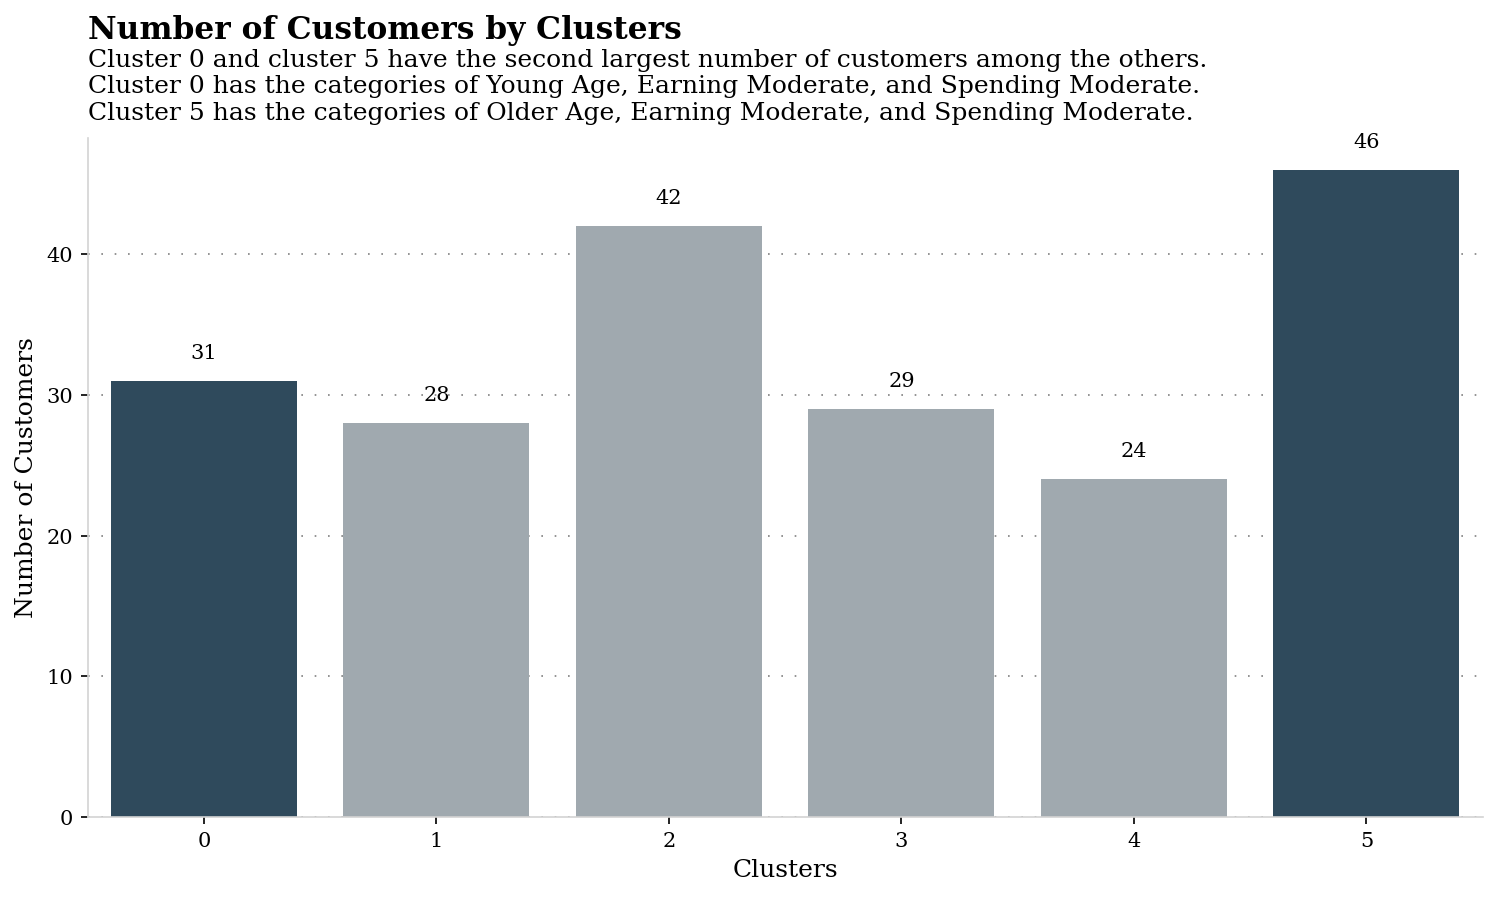

In [36]:
fig, ax = plt.subplots(1,1, figsize=(12, 6), dpi=150)

color_map = ['#9DA9B1' for _ in range(16)]
color_map[0] = color_map[5] = '#284B63' 

sns.barplot(x='clusters', y='CustomerID', data=analysis_cluster, palette=color_map)

for i, j in analysis_cluster.iterrows():
  ax.annotate(f"{j['CustomerID']}", xy=(i, j['CustomerID']+2), va = 'center', ha='center',fontweight='light', fontfamily='serif')

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

for t in ['left', 'bottom']:
    ax.spines[t].set_color('lightgray')

ax.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,7))

yticklabels = np.arange(0, 45, 10)
xticklabels = analysis_cluster['clusters']
ax.set_xticklabels(xticklabels, fontfamily='serif', rotation=0)
ax.set_yticklabels(yticklabels, fontfamily='serif', rotation=0)
ax.set_axisbelow(True)

plt.xlabel('Clusters', fontsize=12, fontweight='light', fontfamily='serif')
plt.ylabel('Number of Customers', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.125, .99, 'Number of Customers by Clusters', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(.125, .9, 'Cluster 0 and cluster 5 have the second largest number of customers among the others.\nCluster 0 has the categories of Young Age, Earning Moderate, and Spending Moderate.\nCluster 5 has the categories of Older Age, Earning Moderate, and Spending Moderate.', fontsize=12, fontweight='light', fontfamily='serif')

plt.show()

In [135]:
cluster_analysis = clustering_2.copy()
cluster_analysis = cluster_analysis.groupby('clusters')['Gender'].value_counts().unstack()
cluster_analysis['number_of_customers'] = cluster_analysis.sum(axis=1)

In [136]:
gender_ratio = ((cluster_analysis.T / cluster_analysis['number_of_customers'] * 100)).T[['Male', 'Female']][::-1]

Text(0.825, 0.9, 'Female')

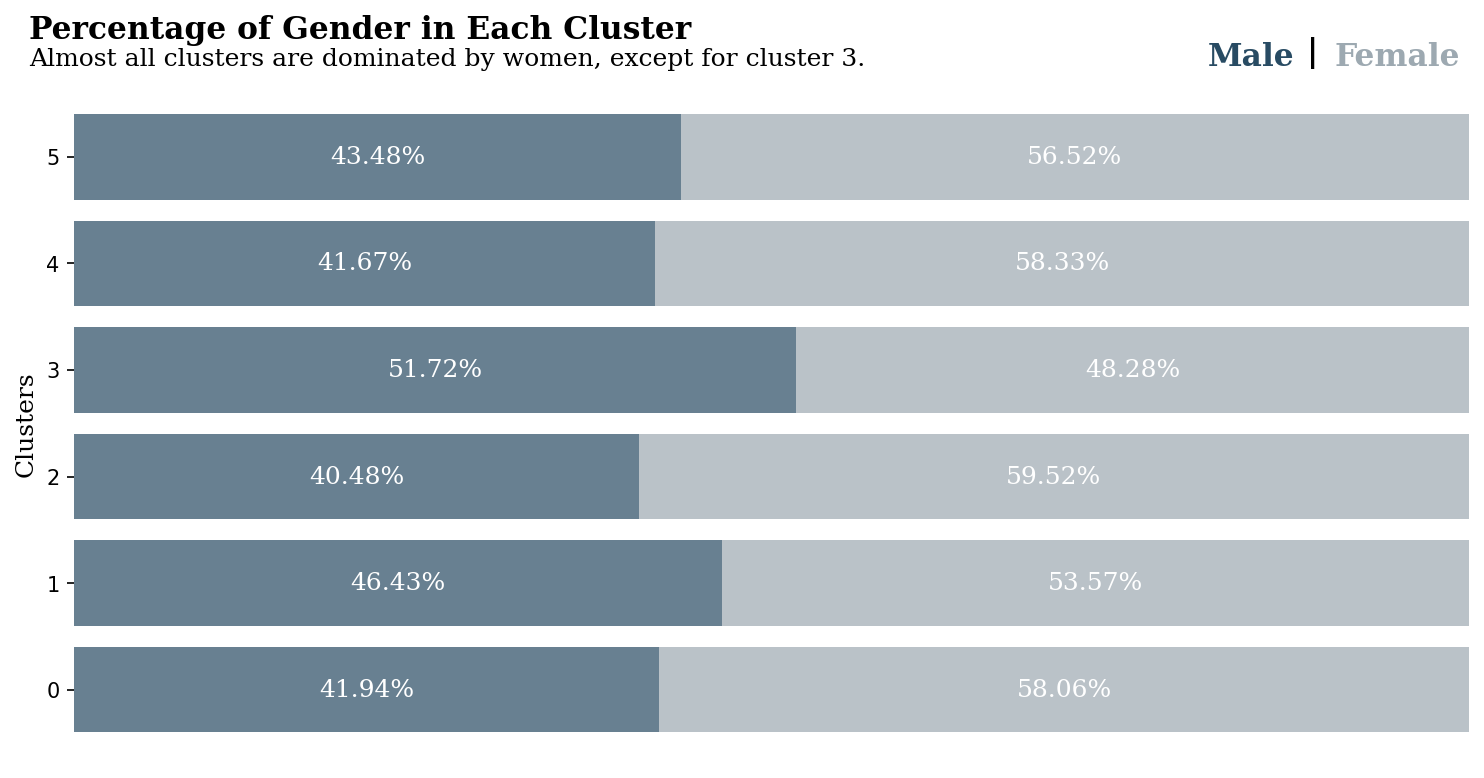

In [137]:
fig, ax = plt.subplots(1,1, figsize=(12, 6), dpi=150)

ax.barh(gender_ratio.index, gender_ratio['Male'], 
        color='#284B63', alpha=0.7, label='Male')
ax.barh(gender_ratio.index, gender_ratio['Female'], left=gender_ratio['Male'], 
        color='#9DA9B1', alpha=0.7, label='Female')

for i in gender_ratio.index:
    ax.annotate(f"{round(gender_ratio['Male'][i], 2)}%", 
                   xy=(gender_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in gender_ratio.index:
    ax.annotate(f"{round(gender_ratio['Female'][i], 2)}%", 
                   xy=(gender_ratio['Male'][i]+gender_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

for t in ['left', 'bottom']:
    ax.spines[t].set_color('lightgray')

ax.set_xlim(0, 100)
ax.set_xticks([])

ax.set_axisbelow(True)

plt.ylabel('Clusters', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.1, .93, 'Percentage of Gender in Each Cluster', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(.1, .9, 'Almost all clusters are dominated by women, except for cluster 3.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.755, .9,'Male', fontweight='bold', fontfamily='serif', fontsize=15, color='#284B63')
fig.text(.810, .905,'|', fontweight='bold', fontfamily='serif', fontsize=15, color='black')
fig.text(.825, .9,'Female', fontweight='bold', fontfamily='serif', fontsize=15, color='#9DA9B1')

# Conclusions

1. Customers are dominated by the age of 20 - 39 years.

2. Customers aged 20 - 59 years are dominated by women.

3. Customers aged 30 - 49 years have Annual Income above the average.

4. Customers aged 20 - 39 years and 70 - 79 years have a Spending Score above the average. Keep in mind that customers aged 70 - 79 years are only 2 customers.

5. There is a negative correlation between age and spending score, the higher the age, the lower the spending score.

6. There is a clear pattern between the Annual Income and Spending Score features, there are 5 cluster patterns.

7. There are 6 clusters (clusters 0 - 5) from the features of age, Annual Income, and Spending Score.

8. Cluster 0 and Cluster 5 have the two largest number of customers.

9. Cluster 0 has the category of Young Age, Earning Moderate, Spending Moderate, and is dominated by women.

10. Cluster 1 has the category of Older Age, Earning High, Spending Low, and is dominated by men.

11. Cluster 2 has the category of Older Age, Earning Low, Spending Low, and is dominated by women.

12. Cluster 3 has categories of Young Age, Earning Low, Spending High, and is dominated by women.

13. Cluster 4 has categories of Young Age, Earning High, Spending High, and is dominated by women.

14. Cluster 5 has the category of Older Age, Earning Moderate, Spending Moderate, and is dominated by women.

15.  Younger customers (< 39 years) have a Spending Score of Moderate - High and older customers (> 39 Years) have a Spending Score of Low - Moderate. Younger customers are dominated by women.